<a href="https://colab.research.google.com/github/martinmwarangu/Pyspark_Msc/blob/main/Linear_Regression_PySpark_CN7030.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Linear Regression and Regularization with Mathematical Insights: PySpark ML on Diabetes Data**



In [ ]:
!pip3 install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f27350f90b88ed0b54bc6a7b77dca133419239384974a6b92a93b2a94b82cbba
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# **Step 1:** Import the required libraries and initialize SparkSession.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegressionExample") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

spark

# **Step 2:** Load and preprocess the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Description

Diabetes Data: https://drive.google.com/file/d/1JgxAN-lTKXbrsaHtetOpybk4XTLRYqCF/view?usp=sharing (204 MB)

We have a dataset of diabetes patients, including ten health measurement features and one variable indicating disease progression after one year.

| Feature 	| Description                           	|
|---------	|---------------------------------------	|
| age     	| Age in years                          	|
| sex     	| Sex                                   	|
| bmi     	| Body Mass Index                       	|
| bp      	| Average blood pressure                	|
| tc      	| T-Cells (a type of white blood cells) 	|
| ldl     	| low-density lipoproteins              	|
| hdl     	| high-density lipoproteins             	|
| tch     	| thyroid stimulating hormone           	|
| ltg     	| lamotrigine                           	|
| glu     	| blood sugar level                     	|

In [ ]:
# Load the data from a CSV file
df = spark.read.csv("/content/drive/MyDrive/diabetes_wk_4/Diabetes.csv", header=True, inferSchema=True)

# get familiar with data
df.show()

# more info
print(df.count())
print(df.rdd.getNumPartitions())

+---+---+------+-----+------+------+-----+-----+----+-----+------+-----------+
| id|age|   sex|  bmi|    bp|    tc|  ldl|  hdl| tch|  ltg|   glu|progression|
+---+---+------+-----+------+------+-----+-----+----+-----+------+-----------+
|  0| 22|  Male|20.33|106.25|140.89|-0.45|62.83|0.77|-0.54|130.98|      29.83|
|  1| 41|Female|25.99|132.23|129.64|-1.11|37.26|0.81| 1.64|151.19|      46.66|
|  2| 51|Female|32.76| 127.0|220.36|-1.69|49.56|0.41|-0.88|176.22|      59.97|
|  3| 26|  Male|35.87| 138.4|194.19|-0.04|55.57|0.45|-1.38|125.32|      42.44|
|  4| 42|Female| 21.5|122.33|275.79| 1.19|63.64|0.54|-0.69|184.72|      49.36|
|  5| 47|  Male|31.62|137.18|232.35|-1.65|36.68|0.26| 1.63| 99.83|      54.15|
|  6| 22|  Male|37.06|106.47|244.34|-0.07|34.22|0.48|-1.72| 65.41|      39.55|
|  7| 23|  Male|26.75|129.39|177.69|-0.37|42.03|0.68| 0.82|180.71|      33.12|
|  8| 44|Female|28.38|125.23|276.99| 0.69|55.18| 1.1|-0.52|134.71|      53.84|
|  9| 36|  Male|36.83| 121.9|174.81|  1.1|53.55|0.25

# StringIndexer

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="sex", outputCol= "gender")
df = indexer.fit(df).transform(df)
df.show(10)

+---+---+------+-----+------+------+-----+-----+----+-----+------+-----------+------+
| id|age|   sex|  bmi|    bp|    tc|  ldl|  hdl| tch|  ltg|   glu|progression|gender|
+---+---+------+-----+------+------+-----+-----+----+-----+------+-----------+------+
|  0| 22|  Male|20.33|106.25|140.89|-0.45|62.83|0.77|-0.54|130.98|      29.83|   1.0|
|  1| 41|Female|25.99|132.23|129.64|-1.11|37.26|0.81| 1.64|151.19|      46.66|   0.0|
|  2| 51|Female|32.76| 127.0|220.36|-1.69|49.56|0.41|-0.88|176.22|      59.97|   0.0|
|  3| 26|  Male|35.87| 138.4|194.19|-0.04|55.57|0.45|-1.38|125.32|      42.44|   1.0|
|  4| 42|Female| 21.5|122.33|275.79| 1.19|63.64|0.54|-0.69|184.72|      49.36|   0.0|
|  5| 47|  Male|31.62|137.18|232.35|-1.65|36.68|0.26| 1.63| 99.83|      54.15|   1.0|
|  6| 22|  Male|37.06|106.47|244.34|-0.07|34.22|0.48|-1.72| 65.41|      39.55|   1.0|
|  7| 23|  Male|26.75|129.39|177.69|-0.37|42.03|0.68| 0.82|180.71|      33.12|   1.0|
|  8| 44|Female|28.38|125.23|276.99| 0.69|55.18| 1.1|-

# VectorAssembler

In [ ]:
assembler = VectorAssembler(inputCols=["age","gender","bmi","bp","tc", "ldl","hdl","tch", "tch","ltg", "glu"], outputCol="features")
data = assembler.transform(df)
data = data.select("features", "progression")
data.show(5, truncate= False)

+-----------------------------------------------------------------+-----------+
|features                                                         |progression|
+-----------------------------------------------------------------+-----------+
|[22.0,1.0,20.33,106.25,140.89,-0.45,62.83,0.77,0.77,-0.54,130.98]|29.83      |
|[41.0,0.0,25.99,132.23,129.64,-1.11,37.26,0.81,0.81,1.64,151.19] |46.66      |
|[51.0,0.0,32.76,127.0,220.36,-1.69,49.56,0.41,0.41,-0.88,176.22] |59.97      |
|[26.0,1.0,35.87,138.4,194.19,-0.04,55.57,0.45,0.45,-1.38,125.32] |42.44      |
|[42.0,0.0,21.5,122.33,275.79,1.19,63.64,0.54,0.54,-0.69,184.72]  |49.36      |
+-----------------------------------------------------------------+-----------+
only showing top 5 rows



# StandardScaler

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledfeatures")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)
data = data.select("scaledfeatures","progression")
data.show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|scaledfeatures                                                                                                                                                                                                   |progression|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[2.1992963818959104,1.9999996870586678,2.9065868277628337,10.626733865679874,2.817908021189971,-0.44952529926154455,6.283784722870423,3.851676742960024,3.851676742960024,-0.5397422170510016,2.6192099652139484]|29.83      |
|[4.098688711715106,0.0,3.7157989008143653,13.225157826436233,2.592899395748938,-1.1088290715118099,3.72

In [ ]:
from os import truncate
# splitting data into training and testing sets
train_data,test_data = data.randomSplit((0.7,0.3), seed=42)
train_data.show(5, truncate==False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|scaledfeatures                                                                                                                                                                                                     |progression|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[-0.9996801735890501,1.9999996870586678,4.513573347391671,14.255325909415083,4.911188264626287,-0.29968353284102967,3.6984618661745694,3.5515460876644376,3.5515460876644376,0.6896706106762797,2.2420661268879822]|7.79       |
|[-0.59980810415343,0.0,3.554242426865915,12.855097447113735,3.8849489249481164,-1.0688712671330

# **Step 3:** Apply linear regression model.

In [ ]:
lr = LinearRegression(labelCol="progression" ,featuresCol="scaledfeatures" ,predictionCol="predictions")
lr_model = lr.fit(train_data)
lr_predictions= lr_model.transform(test_data)
lr_predictions.select("predictions", "progression").show(10, truncate=False)

+------------------+-----------+
|predictions       |progression|
+------------------+-----------+
|12.84322127631629 |12.84      |
|15.782732312119713|15.78      |
|13.361615339783713|13.36      |
|12.107232785669735|12.11      |
|12.397431427691126|12.4       |
|14.913638804692889|14.91      |
|15.613728583841377|15.61      |
|16.151324389236265|16.15      |
|17.704219575213344|17.7       |
|12.022124491648027|12.02      |
+------------------+-----------+
only showing top 10 rows



In [ ]:
#access the coefficients of the model
coefficients = lr_model.coefficients
intercept = lr_model.intercept
print(coefficients)
print(intercept)


[8.502719703571548,-5.546469333252984e-06,3.4972267680420206,0.09998470261214139,-1.8898950987326377e-06,1.0010564864246805,2.456221854031589e-06,-0.009997852913367486,-0.009997852913353217,-0.8003841064036297,5.798997544627856e-07]
3.309550543955053e-05


# **Step 4:** Apply Lasso and Ridge regression models.
For Lasso regression, you would set elasticNetParam to 1.0, indicating that you want to use L1 regularization. For Ridge regression, you would set elasticNetParam to 0.0, indicating that you want to use L2 regularization.


In [ ]:
lasso = LinearRegression(labelCol="progression" ,featuresCol="scaledfeatures", predictionCol="predictions",
                         elasticNetParam=1.0,regParam=0.15)
lasso_model = lasso.fit(train_data)
lasso_predictions = lasso_model.transform(test_data)
#ridge model
ridge = LinearRegression(labelCol="progression" ,featuresCol="scaledfeatures", predictionCol="predictions",
                         elasticNetParam=0.0,regParam=0.15)
ridge_model = ridge.fit(train_data)
ridge_predictions = ridge_model.transform(test_data)
lasso_predictions.select("predictions","progression").show(5,truncate=False)



+------------------+-----------+
|predictions       |progression|
+------------------+-----------+
|13.466536080642978|12.84      |
|16.332266266068352|15.78      |
|14.249967702443584|13.36      |
|12.841207993794853|12.11      |
|13.301085179245103|12.4       |
+------------------+-----------+
only showing top 5 rows



# **Step 5:** Evaluate the models and visualize the results.

In [ ]:
evaluator_mse = RegressionEvaluator(labelCol="progression", predictionCol="predictions", metricName="mse")
# caLculating mse
mse1 = evaluator_mse.evaluate(lr_predictions)
mse2 = evaluator_mse.evaluate(lasso_predictions)
mse3 = evaluator_mse.evaluate(ridge_predictions)
#rmse
evaluator_rmse = RegressionEvaluator(labelCol="progression", predictionCol="predictions", metricName="rmse")
rmse1 = evaluator_rmse.evaluate(lr_predictions)
rmse2 = evaluator_rmse.evaluate(lasso_predictions)
rmse3 = evaluator_rmse.evaluate(ridge_predictions)
#r2
evaluator_r2 = RegressionEvaluator(labelCol="progression", predictionCol="predictions" ,metricName="r2")
r2_score_1 = evaluator_r2.evaluate(lr_predictions)
r2_score_2 = evaluator_r2.evaluate(lasso_predictions)
r2_score_3 = evaluator_r2.evaluate(ridge_predictions)



In [ ]:
# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score_1)
print('Lasso - MSE: ', mse2, ', RMSE: ', rmse2, ', R^2: ', r2_score_2)
print('Ridge - MSE: ', mse3, ', RMSE: ', rmse3, ', R^2: ', r2_score_3)


Regression - MSE:  8.338459714005462e-06 , RMSE:  0.0028876391246146845 , R^2:  0.9999999030699728
Lasso - MSE:  0.10010649005685825 , RMSE:  0.3163960967787976 , R^2:  0.9988363168811288
Ridge - MSE:  0.021746401220939706 , RMSE:  0.1474666105290947 , R^2:  0.9997472099962487


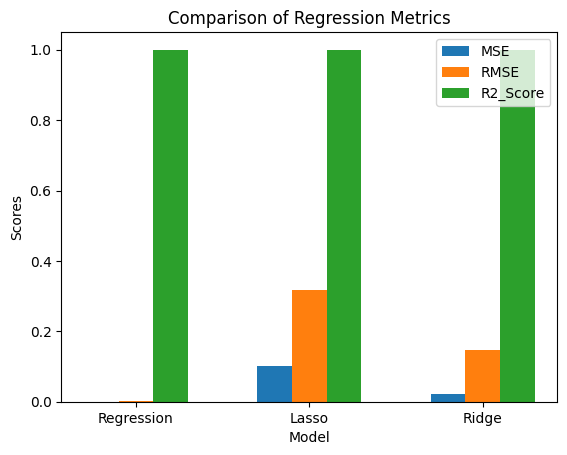

In [ ]:
# plot the graph
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mse2, mse3]
rmse = [rmse1, rmse2, rmse3]
r2_score = [r2_score_1, r2_score_2, r2_score_3]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()